### Outline

1) Introdução

2) Metodologia

    - Descrição dos procedimentos
    
3) Análise Descritiva e Limpeza    

    - Histogramas
    
    - Normalizacao 
    
4) Modelagem

    * Redução de dimensionalidade
    
        - UMAP
        
    * Clusterização
    
        - GMM
        
    * Classificação 
    
        - glmnet
        
        - Random Forest
        
5) Resultados e conclusões

# 1. Introdução

Uma grande multinacional varejista do ramo de supermercados deseja ingressar no mercado brasileiro. Você é o responsável pela análise que servirá de base para a estratégia (tomada de decisão) de entrada dessa empresa no Brasil.
A escolha do local é uma das decisoes mais importantes que deve-se levar em consideração durante a implementação de uma nova franquia de varejo, pois determina a vantagem completitiva sobre outras franquias.

O objetivo desde notebook é ELABORAR e IMPLEMENTAR os seguintes itens:


 *  **Realizar uma clusterização dos municípios brasileiros com base nas informações disponíveis e fazer uma caracterização dos           municípios em grupos.**
 
 *  **Elaborar uma forma de classificar um novo município entre os grupos já criados na etapa anterior**
 
 * **Responder quais grupos de municípios deveriam ser a porta de entrada para empresa no país e porque.**
 

In [1]:
import os
import pandas as pd
import numpy as np
import scipy

import sklearn as sk
import shap
from umap import UMAP
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture

import matplotlib.pyplot as plt
import seaborn

os.getcwd()

'/projects'

# 2. Análise descritiva e limpeza dos dados

Antes de começarmos a modelagem dos dados, devemos selecionar somente as columas numéricas que representam as nossas variáveis onde queremos realizar a clusterização das observações. Como as variáveis estão em diferentes escalas, e iremos utilizar técnicas de redução de dimensionalidade que sao baseados em KNN, é de grande ajuda converter as features em z-scores ou normalizá-las em seu range (minmax)

In [2]:
## leitura do dataset
diretorio = "/projects/data/raw/dados_municipais.csv"
dados_municipais = pd.read_csv(diretorio, sep = ",")

In [5]:
## Selecionando somente as colunas numéricas
columns = [ 
	   'Densidade_demográfica_2000', 'Distância_à_capital_km_',
       'Esperança_de_vida_ao_nascer_2000',
       'Mortalidade_até_um_ano_de_idade_2000',
       'Taxa_de_fecundidade_total_2000',
       'Percentual_de_pessoas_de_25_anos_ou_mais_analfabetas_2000',
       'Renda_per_Capita_2000', 'Índice_de_Gini_2000',
       'Intensidade_da_indigência_2000', 'Intensidade_da_pobreza_2000',
       'Índice_de_Desenvolvimento_Humano_Municipal_2000',
       'Taxa_bruta_de_freqüência_à_escola_2000', 'Taxa_de_alfabetização_2000',
       'Média_de_anos_de_estudo_das_pessoas_de_25_anos_ou_mais_de_idade_2000',
       'População_de_25_anos_ou_mais_de_idade_1991',
       'População_de_25_anos_ou_mais_de_idade_2000',
       'População_de_65_anos_ou_mais_de_idade_1991',
       'População_de_65_anos_ou_mais_de_idade_2000', 'População_total_1991',
       'População_total_2000', 'População_urbana_2000',
       'População_rural_2000'
    ]

dados_municipais_numericFeatures = dados_municipais[columns].values
dados_municipais_numericFeatures.shape

## normalizacao
scale = sk.preprocessing.MinMaxScaler()
minmax = scale.fit_transform(dados_municipais_numericFeatures)
df_std = pd.DataFrame(minmax)
df_std.columns = columns


------------------------------------------

### 2.1 - Análise Exploratória

A seguinte tabela mostra as estatisticas descritivas das variáveis numéricas do dataset.
 

In [6]:
## estatisticas descritivas do dataset
print(df_std.shape)
#dados_municipais.describe().transpose()
df_std.describe().transpose()

(5360, 22)


,count,mean,std,min,25%,50%,75%,max
Densidade_demográfica_2000,5360.0,0.007417,0.040881,0.0,0.000869,0.001824,0.003689,1.0
Distância_à_capital_km_,5360.0,0.171785,0.110823,0.0,0.082624,0.154661,0.242701,1.0
Esperança_de_vida_ao_nascer_2000,5360.0,0.561566,0.203722,0.0,0.426353,0.582459,0.715904,1.0
Mortalidade_até_um_ano_de_idade_2000,5360.0,0.275640,0.177007,0.0,0.128008,0.231374,0.391600,1.0
Taxa_de_fecundidade_total_2000,5360.0,0.209861,0.119769,0.0,0.123596,0.178170,0.268058,1.0
Percentual_de_pessoas_de_25_anos_ou_mais_analfabetas_2000,5360.0,0.361973,0.222020,0.0,0.175996,0.302682,0.554404,1.0
Renda_per_Capita_2000,5360.0,0.153251,0.103588,0.0,0.062606,0.140526,0.220017,1.0
Índice_de_Gini_2000,5360.0,0.437143,0.127735,0.0,0.347826,0.434783,0.521739,1.0
Intensidade_da_indigência_2000,5360.0,0.563686,0.119236,0.0,0.485056,0.560512,0.639052,1.0
Intensidade_da_pobreza_2000,5360.0,0.466455,0.159645,0.0,0.333841,0.454289,0.590159,1.0


In [ ]:
# set a grey background (use sns.set_theme() if seaborn version 0.11.0 or above) 
seaborn.set(style = "darkgrid")
fig, axes = plt.subplots(7,2, figsize = (12,40))
for i, j in zip(df_std.columns[1:15], range(0, 13)):
    df_std.hist("{0}".format(i), bins = 22 , ax = axes[j])

In [ ]:
#Inserir aqui o motivo da escolha das variaveis 1:14


In [7]:
features_treino = df_std.columns[1:14]
df_treino = df_std[features_treino]

----------------------------------

# 3. Modelagem

## 3.1 - Redução de dimensionalidade

No âmbido do big data, métodos de redução de dimensionalidade são ubíquos. Essas técnicas nos permitem visualizar e sumarizar os dados em espaços topológicos com dimensão inferior àquelas dos dados originais

### UMAP


UMAP é um acrônimo para **Uniform Manifold Aproximation and Projection**. UMAP é utilizado como uma técnica de redução de dimensionalidade. Assim, quando temos um conjunto de dados com um número de variáveis elevado (k > 3), utiliza-se UMAP para projetar essas variáveis num espaço topológico de menor dimensão onde a estrutura original dos dados é preservada.


In [ ]:
#fig, axes =  plt.subplots(9, figsize = (15, 100))
for i, j in zip(itertools.product([25, 50, 100, 200, 300, 400, 500, 600], [0.1, 0.2, 0.3, 0.4, 0.5, 0.6]), range(48)):
    redim = UMAP(n_neighbors = i[0], min_dist = i[1], n_components = 5)
    emb = redim.fit_transform(minmax)
    plt.scatter(emb[:,2], emb[:,4])

Após uma busca intensiva no espaço hiperparamétrico, os melhores valores para os hiperparâmetros do UMAP são:

 - n_neighbors = 100
 - min_dist = 0.2
 - n_components = 6
 - metric = 'correlation'


In [175]:
umap = UMAP(random_state=124104, n_neighbors = 300,  min_dist = 0.155, n_components = 6, metric = 'chebyshev')
UMAP_embedding = umap.fit_transform(df_treino)
embedding = pd.DataFrame(UMAP_embedding)
embedding.columns = ["emb0","emb1","emb2","emb3","emb4","emb5"]
#chebyshev performs better than mahalanobis
#correlation metric has performed better than chebyshev

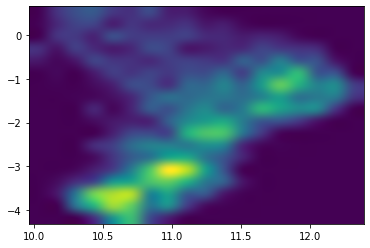

<Figure size 432x288 with 0 Axes>

In [190]:
#emb1,7
heatmap, xedges, yedges = np.histogram2d(embedding['emb2'], 
                                         embedding['emb5'], bins=18)

extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
plt.grid(False)
plt.imshow(heatmap.T, extent=extent, origin='lower',cmap="viridis",aspect="auto", interpolation="catrom",interpolation_stage="rgba")
plt.show()
plt.clf()

In [192]:
embedding.to_csv("umap_embs_300-0155-chebyschev")

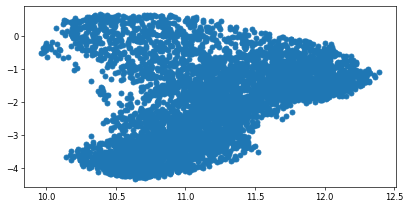

In [191]:
#1,4#
plt.figure(figsize=(8, 4), dpi=60)
plt.scatter(UMAP_embedding[:,2], UMAP_embedding[:,5])

## 3.2. Clusterização

O Mapa de calor a seguir mostra os pontos de maior densidade, indicando os possíveis clusters.
Devido à anisotropia presente na projeção dos dados obtidos pelo processo de redução de dimensionalidade e nas multiplas vizinhanças onde a densidade da distribuição é elevada, temos indícios de que um modelo gaussiano misto (GMM) possa ser adequado para realizar a clusterizacao dos municipios


### 3.2.1. - GMM 

Gaussian Mixture Models ou Modelo de Misturas Gaussianas é um modelo probabilístico paramétrico onde ajustamos uma combinação linear convexa de componentes probabilisticas com distribuição normal.
Um GMM com K componentes é dado pela expressão:

$$f(x) = \sum_{i=1}^K \pi_i N(\pmb{x}| \pmb{\mu}_i, \Sigma_i)$$

Em que  \
$\mu_i$: vetor de médias da i-ésima componente \
$\Sigma_i$: matriz de variância-covariância da i-ésima componente \
$ 0 \leq \pi_i \leq 1;   \sum_{i=1}^K \pi_i = 1$

No GMM é necessário estimar $3K$ parâmetros:

$$(\pi_1 \ldots \pi_K,\mu_K, \ldots, \mu_K, \Sigma_1, \ldots, \Sigma_K)$$

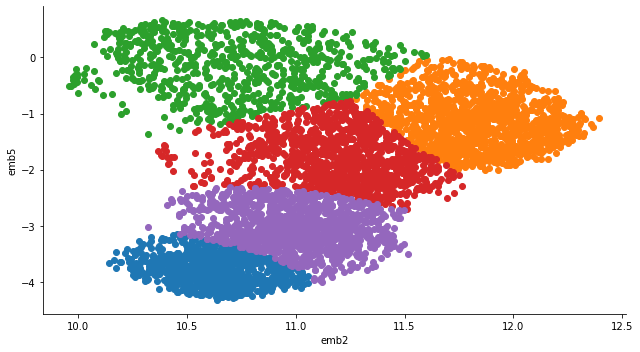

In [195]:
np.random.seed(561)
#np.random.seed(6114)
gmm = GaussianMixture(n_components = 5, init_params = "kmeans", max_iter = 100, covariance_type = 'diag' )

gmm = gmm.fit(embedding[["emb2","emb5"]])

mixtures = pd.DataFrame({"model" : gmm.predict(embedding[["emb2","emb5"]])})

df_c = pd.concat([embedding[["emb2","emb5"]],  mixtures.reset_index(drop = True)], axis = 1)


df_c.columns = ['emb2','emb5',"cluster"]

#plotting clusters
fg = seaborn.FacetGrid(data=df_c, hue = 'cluster', aspect=1.8,height =5)
fg.map(plt.scatter, 'emb2',"emb5")

In [196]:
dados_clusterizados = pd.DataFrame(df_std)
dados_clusterizados.columns = columns
dados_clusterizados = pd.concat([dados_clusterizados, mixtures.reset_index(drop = True)], axis = 1)
print("Quantidade de observações por cluster:")
dados_clusterizados.groupby(['model'])['model'].count()

Quantidade de observações por cluster:


model
0     899
1    1291
2     736
3    1173
4    1261
Name: model, dtype: int64

In [205]:
dados_clusterizados.to_csv("clustered_dataset")

### Definindo a quantidade ideal de componentes

In [198]:
np.random.seed(151561)

S = []

BIC = []

K = range(2,30)

X = df_c[['emb2', 'emb5']]

for k in K:
    model = GaussianMixture(n_components = k, init_params = "kmeans", max_iter = 100, covariance_type = 'full' )

    labels = model.fit_predict(X)
    
    S.append(sk.metrics.silhouette_score(X, labels, metric = 'euclidean'))
    
    BIC.append(model.bic(X))

Text(0, 0.5, 'BIC')

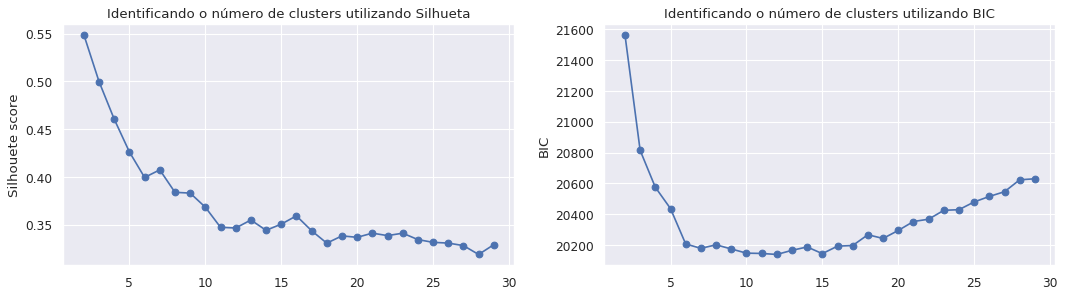

In [199]:
seaborn.set_theme()
fig, (sub,sub1) = plt.subplots(1,2, figsize = (16,4),dpi=80)
sub.plot(K, S, 'bo-')
sub.set_ylabel("Silhouete score")
sub.set_title("Identificando o número de clusters utilizando Silhueta")
sub1.plot(K, BIC, 'bo-')
sub1.set_title("Identificando o número de clusters utilizando BIC")
sub1.set_ylabel('BIC')

# EAD nos clusters

Nesta sessão iremos analisar os clusters obtidos por meio do GMM para extrair o maximo de informações e caracterizá-los.

<AxesSubplot:title={'center':'Histograma para a variável: Intensidade_da_pobreza_2000 (cluster 0) '}>

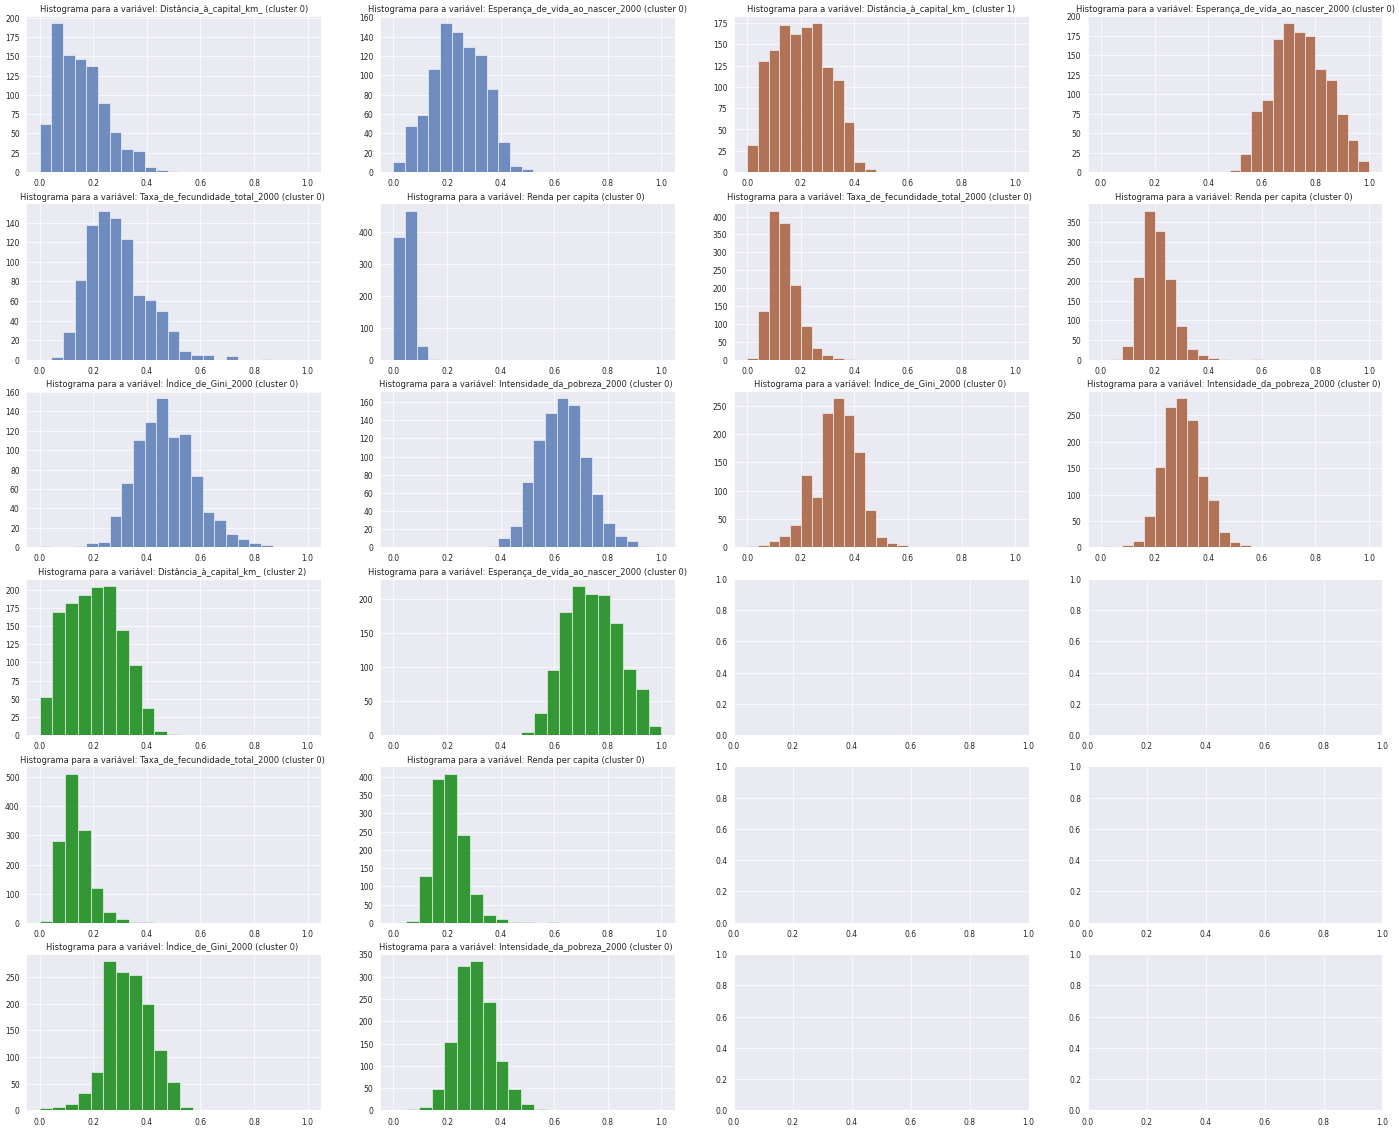

In [201]:
fig, (linha_1 , linha_2, linha_3,linha_4,linha_5,linha_6) = plt.subplots(6,4, figsize = (35,29), dpi = 50)

##cluster 0 
linha_1[0].set_title("Histograma para a variável: Distância_à_capital_km_ (cluster 0)")
dados_clusterizados[dados_clusterizados['model'] == 0]["Distância_à_capital_km_"] \
    .hist(ax = linha_1[0], bins = 23, alpha = 0.78, color = 'b',range=[0, 1])

linha_1[1].set_title("Histograma para a variável: Esperança_de_vida_ao_nascer_2000 (cluster 0)")
dados_clusterizados[dados_clusterizados['model'] == 0]["Esperança_de_vida_ao_nascer_2000"] \
    .hist(ax = linha_1[1], bins = 23, alpha = 0.78, color = 'b',range=[0, 1])

linha_2[0].set_title("Histograma para a variável: Taxa_de_fecundidade_total_2000 (cluster 0) ")
dados_clusterizados[dados_clusterizados['model'] == 0]["Taxa_de_fecundidade_total_2000"] \
    .hist(ax = linha_2[0], bins = 23, alpha = 0.78, color = 'b',range=[0, 1])

linha_2[1].set_title("Histograma para a variável: Renda per capita (cluster 0) ")
dados_clusterizados[dados_clusterizados['model'] == 0]["Renda_per_Capita_2000"] \
    .hist(ax = linha_2[1], bins = 23, alpha = 0.78, color = 'b',range=[0, 1])

linha_3[0].set_title("Histograma para a variável: Índice_de_Gini_2000 (cluster 0) ")
dados_clusterizados[dados_clusterizados['model'] == 0]["Índice_de_Gini_2000"] \
    .hist(ax = linha_3[0], bins = 23, alpha = 0.78, color = 'b',range=[0, 1])


linha_3[1].set_title("Histograma para a variável: Intensidade_da_pobreza_2000 (cluster 0) ")
dados_clusterizados[dados_clusterizados['model'] == 0]["Intensidade_da_pobreza_2000"] \
    .hist(ax = linha_3[1], bins = 23, alpha = 0.78, color = 'b',range=[0, 1])

##cluster 1
linha_1[2].set_title("Histograma para a variável: Distância_à_capital_km_ (cluster 1)")
dados_clusterizados[dados_clusterizados['model'] == 1]["Distância_à_capital_km_"] \
    .hist(ax = linha_1[2], bins = 25, alpha = 0.78, color = 'sienna',range=[0, 1])

linha_1[3].set_title("Histograma para a variável: Esperança_de_vida_ao_nascer_2000 (cluster 0)")
dados_clusterizados[dados_clusterizados['model'] == 1]["Esperança_de_vida_ao_nascer_2000"] \
    .hist(ax = linha_1[3], bins = 25, alpha = 0.78, color = 'sienna',range=[0, 1])

linha_2[2].set_title("Histograma para a variável: Taxa_de_fecundidade_total_2000 (cluster 0) ")
dados_clusterizados[dados_clusterizados['model'] == 1]["Taxa_de_fecundidade_total_2000"] \
    .hist(ax = linha_2[2], bins = 25, alpha = 0.78, color = 'sienna',range=[0, 1])

linha_2[3].set_title("Histograma para a variável: Renda per capita (cluster 0) ")
dados_clusterizados[dados_clusterizados['model'] == 1]["Renda_per_Capita_2000"] \
    .hist(ax = linha_2[3], bins = 25, alpha = 0.78, color = 'sienna',range=[0, 1])

linha_3[2].set_title("Histograma para a variável: Índice_de_Gini_2000 (cluster 0) ")
dados_clusterizados[dados_clusterizados['model'] == 1]["Índice_de_Gini_2000"] \
    .hist(ax = linha_3[2], bins = 25, alpha = 0.78, color = 'sienna',range=[0, 1])


linha_3[3].set_title("Histograma para a variável: Intensidade_da_pobreza_2000 (cluster 0) ")
dados_clusterizados[dados_clusterizados['model'] == 1]["Intensidade_da_pobreza_2000"] \
    .hist(ax = linha_3[3], bins = 25, alpha = 0.78, color = 'sienna',range=[0, 1])

#cluster 2
linha_4[0].set_title("Histograma para a variável: Distância_à_capital_km_ (cluster 2) ")
dados_clusterizados[dados_clusterizados['model'] == 1]["Distância_à_capital_km_"] \
    .hist(ax = linha_4[0], bins = 21, alpha = 0.78, color = 'green',range=[0, 1])


linha_4[1].set_title("Histograma para a variável: Esperança_de_vida_ao_nascer_2000 (cluster 0)")
dados_clusterizados[dados_clusterizados['model'] == 1]["Esperança_de_vida_ao_nascer_2000"] \
    .hist(ax = linha_4[1], bins = 21, alpha = 0.78, color = 'green',range=[0, 1])

linha_5[0].set_title("Histograma para a variável: Taxa_de_fecundidade_total_2000 (cluster 0) ")
dados_clusterizados[dados_clusterizados['model'] == 1]["Taxa_de_fecundidade_total_2000"] \
    .hist(ax = linha_5[0], bins = 21, alpha = 0.78, color = 'green',range=[0, 1])

linha_5[1].set_title("Histograma para a variável: Renda per capita (cluster 0) ")
dados_clusterizados[dados_clusterizados['model'] == 1]["Renda_per_Capita_2000"] \
    .hist(ax = linha_5[1], bins = 21, alpha = 0.78, color = 'green',range=[0, 1])

linha_6[0].set_title("Histograma para a variável: Índice_de_Gini_2000 (cluster 0) ")
dados_clusterizados[dados_clusterizados['model'] == 1]["Índice_de_Gini_2000"] \
    .hist(ax = linha_6[0], bins = 21, alpha = 0.78, color = 'green',range=[0, 1])


linha_6[1].set_title("Histograma para a variável: Intensidade_da_pobreza_2000 (cluster 0) ")
dados_clusterizados[dados_clusterizados['model'] == 1]["Intensidade_da_pobreza_2000"] \
    .hist(ax = linha_6[1], bins = 21, alpha = 0.78, color = 'green',range=[0, 1])


Text(0.5, 1.0, 'Taxa_bruta_de_freqüência_à_escola_2000')

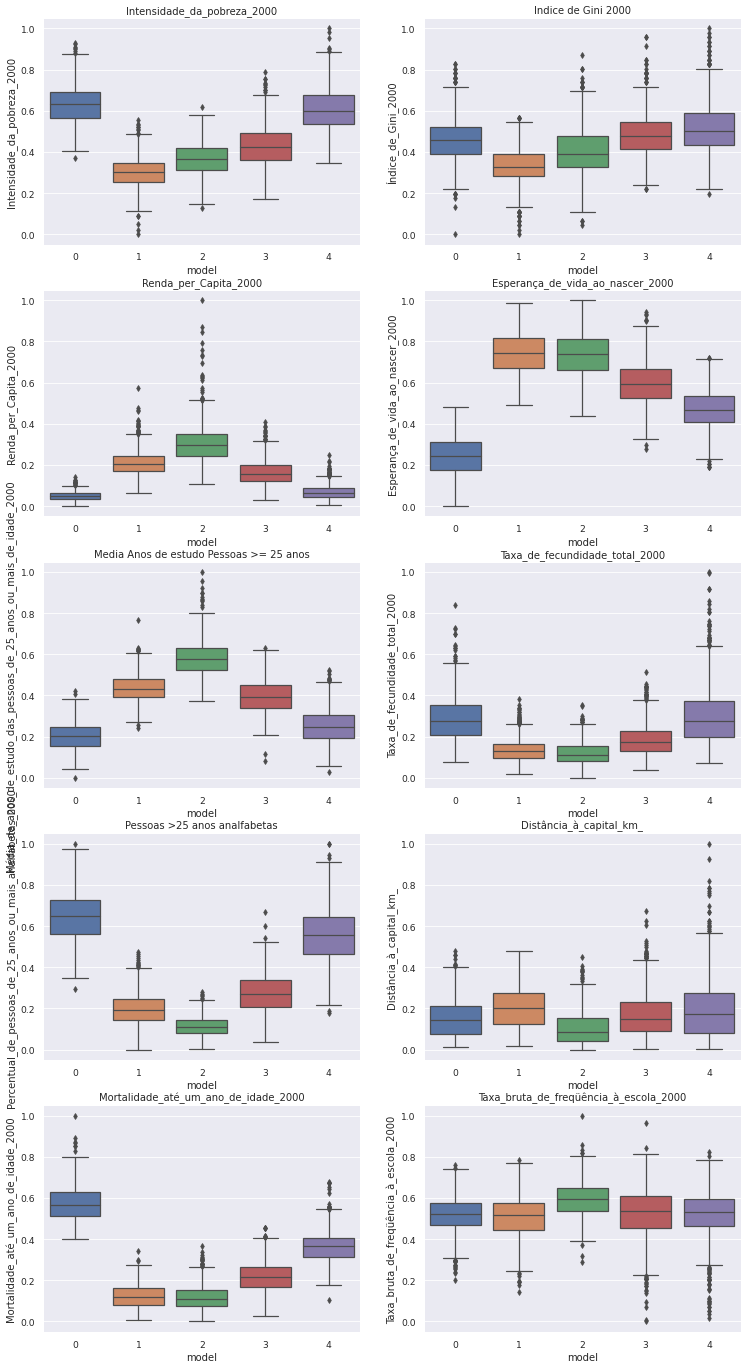

In [207]:
fig, (linha_b_1 , linha_b_2, linha_b_3,linha_b_4,linha_b_5) = plt.subplots(5,2, figsize = (15,29), dpi = 60)
seaborn.boxplot(ax= linha_b_1[0], x = "model", y = "Intensidade_da_pobreza_2000", data = dados_clusterizados,)
linha_b_1[0].set_title('Intensidade_da_pobreza_2000')

seaborn.boxplot(ax= linha_b_1[1], x = "model", y = "Índice_de_Gini_2000", data = dados_clusterizados )
linha_b_1[1].set_title('Indice de Gini 2000')

seaborn.boxplot(ax= linha_b_2[0], x = "model", y = "Renda_per_Capita_2000", data = dados_clusterizados )
linha_b_2[0].set_title('Renda_per_Capita_2000')

seaborn.boxplot(ax= linha_b_2[1], x = "model", y = "Esperança_de_vida_ao_nascer_2000", data = dados_clusterizados )
linha_b_2[1].set_title('Esperança_de_vida_ao_nascer_2000')

seaborn.boxplot(ax= linha_b_3[0], x = "model", y = "Média_de_anos_de_estudo_das_pessoas_de_25_anos_ou_mais_de_idade_2000", data =dados_clusterizados, )
linha_b_3[0].set_title('Media Anos de estudo Pessoas >= 25 anos')

seaborn.boxplot(ax= linha_b_3[1], x = "model", y = "Taxa_de_fecundidade_total_2000", data = dados_clusterizados)
linha_b_3[1].set_title('Taxa_de_fecundidade_total_2000')

seaborn.boxplot(ax= linha_b_4[0], x = "model", y = "Percentual_de_pessoas_de_25_anos_ou_mais_analfabetas_2000", data = dados_clusterizados )
linha_b_4[0].set_title('Pessoas >25 anos analfabetas')

seaborn.boxplot(ax= linha_b_4[1], x = "model", y = "Distância_à_capital_km_", data = dados_clusterizados )
linha_b_4[1].set_title('Distância_à_capital_km_')

seaborn.boxplot(ax= linha_b_5[0], x = "model", y = "Mortalidade_até_um_ano_de_idade_2000", data = dados_clusterizados )
linha_b_5[0].set_title('Mortalidade_até_um_ano_de_idade_2000')


seaborn.boxplot(ax= linha_b_5[1], x = "model", y = "Taxa_bruta_de_freqüência_à_escola_2000", data = dados_clusterizados )
linha_b_5[1].set_title('Taxa_bruta_de_freqüência_à_escola_2000')

#seaborn.boxplot(x = "model", y= "Intensidade_da_pobreza_2000", data =dados_clusterizados )

### Cluster 0
Os municípios do cluster 0 possuem elevados índices de pobreza e desigualdade com índices de renda per capita muito baixos
Esse cluster possui os municipios com as menores expectativas de vida
E elevados indices de analfabetismo em adultos.
o que pode indicar falta de saneamento básico e infra-estrutura em geral.
Essas condições implicam em uma menor expectativa de vida em relação aos demais clusters.
 
 * CARACTERÍSTICAS
  - Rendas per capita muito baixas
  - Maior intensidade de pobreza
  - Elevadas taxas de mortalidade infantil
  - Expectativa de vida muito baixa
  - Elevadas taxas de adultos analfabetos 
  - Municipios subdesenvolvidos

### Cluster 1
Já o cluster 1 engloba os municípios com os menores indices de Gini (maior igualdade) e rendas per-capita razoáveis.
Observa-se o segundo menor indice de analfabetismo em adultos com mais de 25 anos, menos mortalidade infantil e elevada expectativa de vida
As taxas de mortalidade infantil nesse cluster é bem baixa em relação aos outros clusters.
Elevada expectativa de vida e baixa taxa de fecundidade

* CARACTERÍSTICAS
  - Municípios com distribuição de renda mais igualitária
  - menor intensidade de pobreza
  - baixa mortalidade infantil
    
### Cluster 2
Esse é o cluster com maiores indices de riqueza per capita, no entanto observa-se  municipios com indices de gini acima de 0.8, o que indica que alguns municipios nesse cluster possuem elevado indice de desigualdade.
As pessoas tiveram uma quantidade elevada de anos de estudo e observa-se menor indice de analfabetismo.
Nele, também observamos melhores condiçoes de expectativa de vida, o que pode indicar melhores condiçoes sanitarias, menor violência e menor indice de desigualdade. 
Esse cluster também abriga os municípios mais próximos de suas respectivas capitais.

 * CARACTERÍSTICAS
     - Municipios mais desenvolvidos e com melhor infra estrutura
     - maiores indices de alfabetização em adultos
     - distribuição de renda assimpétrica à direita: concentra rendas mais elevadas em poucos municipios

### Cluster 3
   * CARACTERÍSTICAS:
     - Municipios em desenvolvimento
     - Pobreza moderada
     - Municípios desiguais assim como no cluster 0
     - Expectativa de vida razoável

### Cluster 4
  Semelhante ao cluster 1, porém com maiores indices de expectativa de vida e menor mortalidade infantil
  - Compreende muniicípios com maiores distâncias até suas respectivas capitais


# 4. Classificação


In [276]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.experimental import enable_halving_search_cv  # noqa
from sklearn.model_selection import HalvingGridSearchCV

### Split do dataset em Treino e validação

In [236]:
X = df_treino

y = mixtures['model']

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.35, random_state = 35)

### Random Forest

In [315]:
rf_classifier = RandomForestClassifier(random_state = 234)

grid_ = {'max_depth': [3, 5, 10, 15, 20, 21, 23, 25],
         
         'min_samples_split': [2, 5, 10,13,15,16,17,19,20,30],       
         
         'min_samples_split':[10, 40, 70, 90, 120, 160, 200]
        }

sh = HalvingGridSearchCV(rf_classifier, grid_, cv = 10,
                         factor = 2, resource = 'n_estimators',
                         max_resources = 300) \
                        .fit(X_train, y_train)
sh.best_estimator_

RandomForestClassifier(max_depth=25, min_samples_split=10, n_estimators=288,
                       random_state=234)

In [316]:
rf_best = sh.best_estimator_.predict(X_test)

In [318]:
print("F1 macro: {0}".format(sk.metrics.f1_score(y_test, rf_best, average = "macro")))

print("F1 micro: {0}".format(sk.metrics.f1_score(y_test, rf_best, average ="micro")))

print("Acurácia: {0}".format(sk.metrics.accuracy_score(y_pred = rf_best, y_true = y_test)))

print("Matriz de Confusão:")

cm = sk.metrics.confusion_matrix(y_test, rf_best)

pd.DataFrame(cm)

F1 macro: 0.9154685112438296
F1 micro: 0.9152452025586354
Acurácia: 0.9152452025586354
Matriz de Confusão:


,0,1,2,3,4
0,319,0,0,0,11
1,0,401,6,27,0
2,0,15,220,11,0
3,0,38,7,330,12
4,22,0,0,10,447


## Glmnet

* Preproessamento
    - split train test

- describe the model
